# Machine Learning Engineer Nanodegree - 2019
## Capstone Project: Movie Box Office Revenue Prediction with Gradient Boosting Models
Author: Daniel Tejeda

In a world where movies made an estimated 41.7 billion in 2018 and expected to go over 50 billion by 2020, the film industry is more popular than ever. But which movies make the most money at the box office? How much does a director or the budget matter? In this capstone project, I will build a model to answer that question, working with metadata on over 7,000 past films from The Movie Database published as part of TMDB Box Office Prediction Kaggle competition. 


### Project Design

This project will be implemented in Python 3.7. Libraries involved will be numpy, pandas, matplotlib, seaborn, xgboost, lightgbm, catboost, scikit-learn.

The workflow for this project will be in the following order: 
0. Import all libraries
- Exploratory data analysis
- Data cleansing and Feature engineering
- Train the KNN benchmark model based on budget, popularity and runtime
- Stage-1: Boosting Models 
    * Code and train XGBoost model 
    * Code and train CATBoost model
    * Code and train LightGBM model
    * Hyperparameter tuning for the three models
    * Evaluate results against KNN and select new benchmark from the boosting models to be the new benchmark.
    
- Stage 2: Stacked final model
    * Select stacking approach and regression algorithm for the final model
    * Train regression algorithm with the outputs of the base boosting models combined with the original features, according to the stacking approach
    * Hyperparameter tuning for the final model
    * Evaluate and report final results against the benchmark 



## 0. Import all libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import data_prep as dp
import json
from itertools import cycle, islice
from datetime import datetime

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, SGDRegressor, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn import cluster

import xgboost as xgb
import lightgbm as lgb
import catboost as cat
import copy
import itertools


## 1. Exploratory data analysis

In [2]:
dataset_names = ['train','test']

# load original datasets
original_datasets = { ds : pd.read_csv("data/{}.csv".format(ds)) for ds in dataset_names }

# complete missing budget/revenue values from B H's Kernel. (https://www.kaggle.com/zero92/tmdb-prediction)
dp.complete_missing_data(original_datasets)

original_datasets['train'].head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [3]:
n_records = original_datasets['train'].shape[0]
n_columns = original_datasets['train'].shape[1]

print("Total number of records: {}".format(n_records))
print("Total number of features: {}".format(n_columns))

Total number of records: 3000
Total number of features: 23


In [4]:
original_datasets['train'].describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,...,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,...,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt0092226,en,Logan,An inside look at a West Hollywood cult formed...,NaN,...,9/10/15,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Beauty and the Beast,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '5607a7e19251413050003e2c', 'de...",NaN
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,...,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,1500.500000,NaN,2.266135e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,...,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.668176e+07
std,866.169729,NaN,3.702662e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,...,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375149e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,...,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.401550e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,...,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,3.000000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,...,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.877599e+07


Some fields contain list with dictionaries. We will need to extract and transform these features. 

 

### Missing values

In [5]:
desc = pd.DataFrame(original_datasets['train'].isna().sum(), columns=['empty'])
desc

,empty
id,0
belongs_to_collection,2396
budget,0
genres,7
homepage,2054
imdb_id,0
original_language,0
original_title,0
overview,8
popularity,0


### Top 10 revenue movies

In [6]:
original_datasets['train'].sort_values(by='revenue', ascending=False).head(10)[['title','revenue','release_date']]

,title,revenue,release_date
1126,The Avengers,1519557910,4/25/12
1761,Furious 7,1506249360,4/1/15
2770,Avengers: Age of Ultron,1405403694,4/22/15
684,Beauty and the Beast,1262886337,3/16/17
2322,Transformers: Dark of the Moon,1123746996,6/28/11
906,The Dark Knight Rises,1084939099,7/16/12
2135,Pirates of the Caribbean: On Stranger Tides,1045713802,5/14/11
2562,Finding Dory,1028570889,6/16/16
881,Alice in Wonderland,1025491110,3/3/10
734,Zootopia,1023784195,2/11/16


### Distribution of target variable Revenue
Let's take a look at the target variable revenue and how its distributed. We are also plotting the Log1p, since we are going to use this in out model

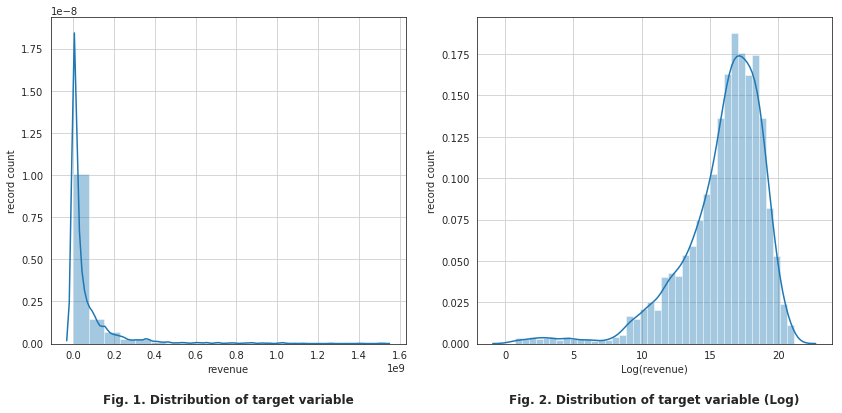

In [7]:
quant_data = original_datasets['train'].set_index('id')[['budget','popularity','runtime', 'revenue']]

sb.set_style("white")

fig, axes = plt.subplots(1, 2, figsize = (14,6))

sb.distplot(quant_data['revenue'], bins=20, kde=True, ax=axes[0])
axes[0].set_title("Fig. 1. Distribution of target variable", y=-0.2, fontweight="bold")
axes[0].set_ylabel('record count')

sb.distplot(np.log1p(quant_data['revenue']), bins=40, kde=True, ax=axes[1])
axes[1].set_title("Fig. 2. Distribution of target variable (Log)",  y=-0.2, fontweight="bold")
axes[1].set_ylabel('record count')
axes[1].set_xlabel('Log(revenue)')

for ax in axes: ax.grid()
    

### Correlation between variables

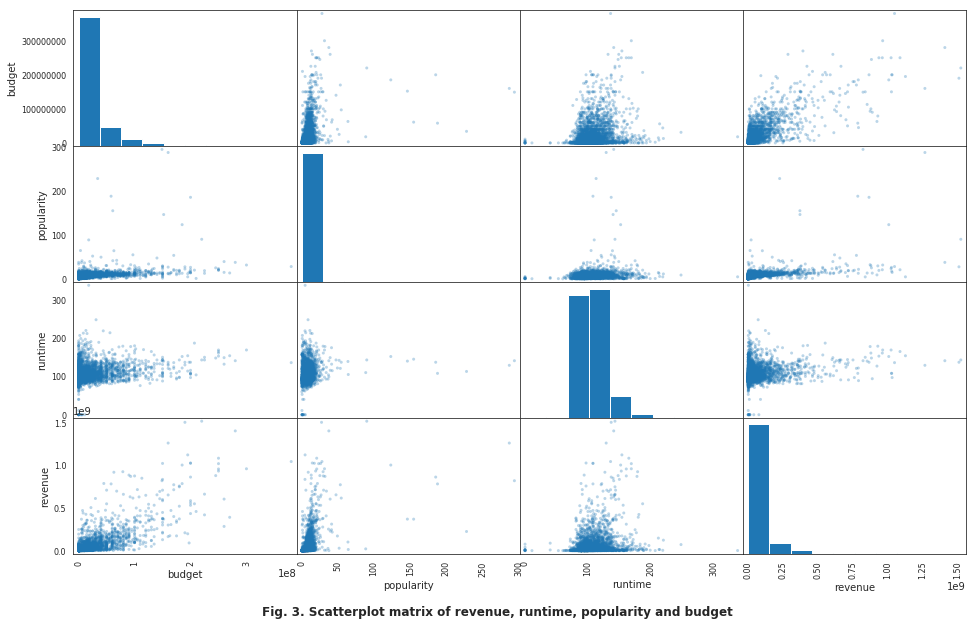

In [8]:
# scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(quant_data, alpha = 0.3, figsize = (16,10))
plt.title("Fig. 3. Scatterplot matrix of revenue, runtime, popularity and budget", y=-0.5, x=-1.1, fontweight="bold");

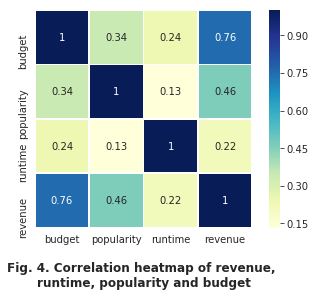

In [9]:
ax = plt.axes()
ax.set_title("Fig. 4. Correlation heatmap of revenue, \nruntime, popularity and budget", y=-0.3, fontweight='bold');
sb.heatmap(quant_data.corr(), annot=True, square=True, linewidths=.5, cmap="YlGnBu", ax=ax);


## 2. Data cleansing and feature engineering

In [10]:
# copy the original dataset and replace NaN with empty string
all_data = original_datasets['train'].set_index('id')

In [11]:
def data_prep_clean_na(data):
    # two movies have NaN runtime, we fill those with the mean
    data['runtime'].fillna(data['runtime'].mean(), inplace=True)

    # replace NaN in strings
    data.fillna('', inplace=True)

data_prep_clean_na(all_data)

In [12]:
def data_prep_dates(data):
    #let's break down month/day/year from release_date
    data[['rel_month','rel_day','rel_year']] = data['release_date'].str.split('/', expand=True).astype(int)

    # fix 2-digit year for 1920-1999
    data['rel_year'] += 1900
    # 2000-2019
    data.loc[data['rel_year'] <= 1919, "rel_year"] += 100

    # extract day of week and quarter
    rel_date = pd.to_datetime(data['release_date']) 
    data['rel_dow'] = rel_date.dt.dayofweek
    data['rel_quarter'] = rel_date.dt.quarter

    
data_prep_dates(all_data)
all_data[['release_date','rel_month','rel_day','rel_year','rel_dow','rel_quarter']].head(3)

,release_date,rel_month,rel_day,rel_year,rel_dow,rel_quarter
id,,,,,,
1,2/20/15,2,20,2015,4,1
2,8/6/04,8,6,2004,4,3
3,10/10/14,10,10,2014,4,4


2013    141
2015    128
2010    126
2016    125
2012    125
Name: rel_year, dtype: int64

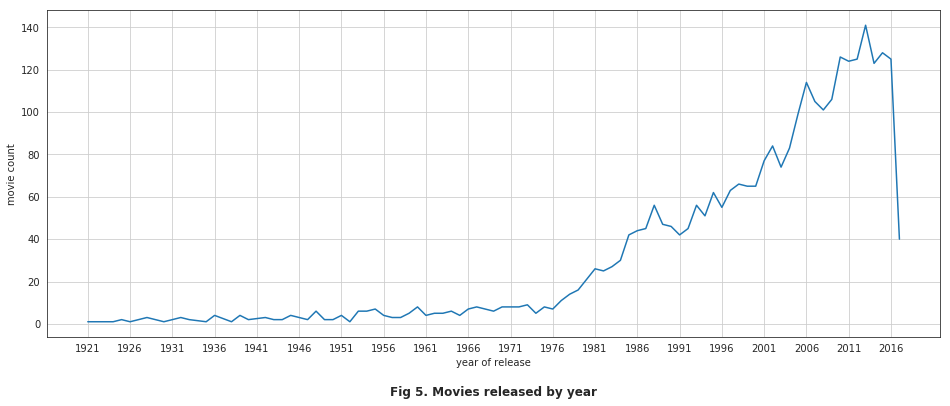

In [13]:
yr_counts = all_data['rel_year'].value_counts().sort_index()
yr_xticks = range(yr_counts.index.values[0],yr_counts.index.values[-1],5)

plt.figure(figsize = (16,6))
plt.plot(yr_counts.index.values, yr_counts.values)
#sb.countplot(all_data['rel_year'])
#plt.xticks(fontsize=12,rotation=90)
plt.xticks(yr_xticks)
plt.ylabel('movie count')
plt.xlabel('year of release')
plt.title("Fig 5. Movies released by year", fontweight="bold", y=-0.2)

plt.grid()
yr_counts.sort_values(ascending=False).head()


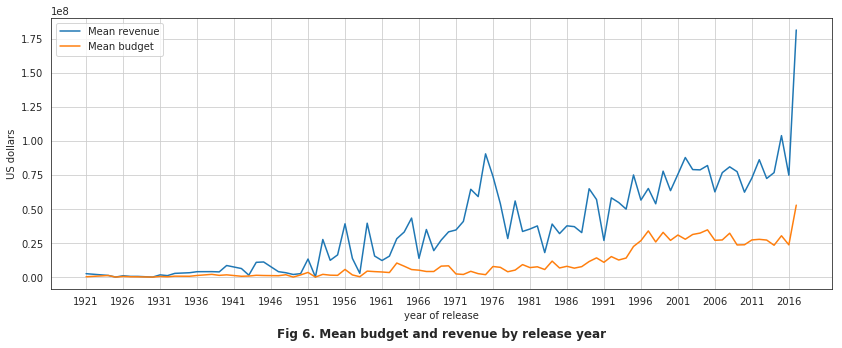

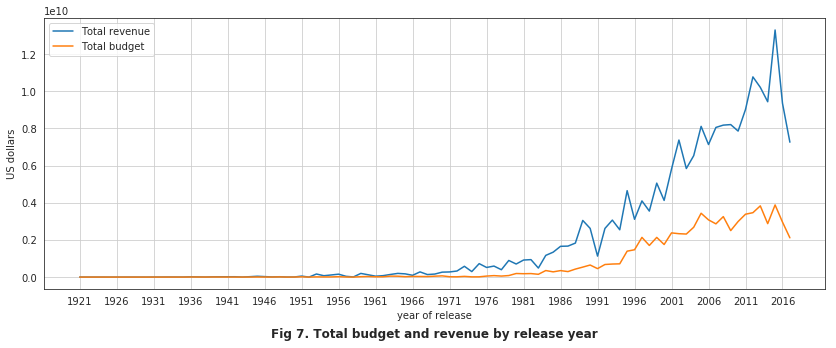

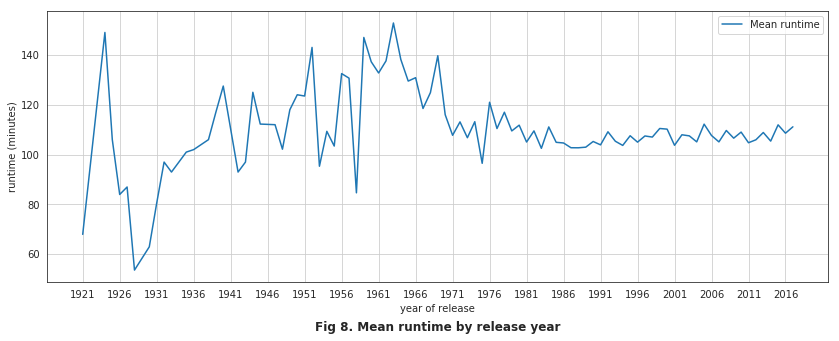

In [39]:
yr_avgs = all_data.groupby('rel_year').mean()
yr_totals = all_data.groupby('rel_year').sum()

plt.figure(figsize=(14, 5))
plt.title("Fig 6. Mean budget and revenue by release year", fontweight="bold", y=-0.2)
plt.plot(yr_avgs.index.values, yr_avgs['revenue'], label='Mean revenue')
plt.plot(yr_avgs.index.values, yr_avgs['budget'], label='Mean budget')
plt.xticks(yr_xticks)
plt.xlabel("year of release")
plt.ylabel("US dollars")
plt.grid()
plt.legend()


plt.figure(figsize=(14, 5))
plt.title("Fig 7. Total budget and revenue by release year", fontweight="bold", y=-0.2)
plt.plot(yr_totals.index.values, yr_totals['revenue'], label='Total revenue')
plt.plot(yr_totals.index.values, yr_totals['budget'], label='Total budget')
plt.xticks(yr_xticks)
plt.xlabel("year of release")
plt.ylabel("US dollars")
plt.grid()
plt.legend()


plt.figure(figsize=(14, 5))
plt.title("Fig 8. Mean runtime by release year", fontweight="bold", y=-0.2)
plt.plot(yr_avgs.index.values, yr_avgs['runtime'], label='Mean runtime')
plt.xticks(yr_xticks)
plt.xlabel("year of release")
plt.ylabel("runtime (minutes)")
plt.grid()
plt.legend();



In [40]:
def data_prep_collection(data, mincount=3):

    # belongs_to_collection
    data['from_collection'] = data['belongs_to_collection'].apply(lambda x: 1 if len(x) > 0 else 0)

    data['collection_name'] = data['belongs_to_collection'].map(lambda x: 'col_{}'.format(dp.get_dictionary(x)[0]['name']) if len(x) > 0 else '')

    collection_names = data['collection_name'].str.translate({ord(i): None for i in '[]<'}).str.get_dummies()
    
    cols = list(collection_names.sum()[collection_names.sum() >= mincount].index)
    
    data[cols] = collection_names[cols]
    
    return cols
    
encoded_cols = data_prep_collection(all_data)
print("Movies that belong to a collection: {} / {}".format(sum(all_data['from_collection']), n_records))
print('{} collection columns added'.format(len(encoded_cols)))
all_data[encoded_cols].rename(lambda x:x[4:], axis='columns').sum().sort_values(ascending=False)

Movies that belong to a collection: 604 / 3000
33 collection columns added


James Bond Collection                        16
Friday the 13th Collection                    7
The Pink Panther (Original) Collection        6
Police Academy Collection                     5
Pokémon Collection                            5
Resident Evil Collection                      4
Alien Collection                              4
Child's Play Collection                       4
Ice Age Collection                            4
Paranormal Activity Collection                4
Rambo Collection                              4
Transformers Collection                       4
Rocky Collection                              4
The Fast and the Furious Collection           4
The Dark Knight Collection                    3
The Wolverine Collection                      3
Cars Collection                               3
The Vengeance Collection                      3
Diary of a Wimpy Kid Collection               3
The Jaws Collection                           3
Halloween Collection                    

In [41]:
def data_prep_homepage(data):
    #homepage
    data['has_homepage'] = data['homepage'].apply(lambda x: 1 if len(x) > 0 else 0)
    
data_prep_homepage(all_data)  
print("Movies with homepage: {} / {}".format(sum(all_data['has_homepage']), n_records))

Movies with homepage: 946 / 3000


In [42]:
def data_prep_genres(data):

    #extract genre information from genre column
    data['genres_new'] = data['genres'].map(lambda x: sorted(['genre_{}'.format(d['name']) for d in dp.get_dictionary(x)])).map(lambda x: '|'.join(map(str, x)))

    #one-hot-encoding 
    genres = data.genres_new.str.get_dummies(sep='|')

    #concatenate one-hot-encoding for genres to data
    data[genres.columns] = genres
    
    return genres.columns


encoded_cols= data_prep_genres(all_data)
print('{} genre columns added'.format(len(encoded_cols)))
all_data[encoded_cols].rename(lambda x:x[6:], axis='columns').sum()

20 genre columns added


Action              741
Adventure           439
Animation           141
Comedy             1028
Crime               469
Documentary          87
Drama              1531
Family              260
Fantasy             232
Foreign              31
History             132
Horror              301
Music               100
Mystery             225
Romance             571
Science Fiction     290
TV Movie              1
Thriller            789
War                 100
Western              43
dtype: int64

In [43]:
def data_prep_cast_crew(data):
    
    for feat in ['cast','crew']:
        totcol = '{}_cnt'.format(feat)
        data[totcol] = 0
        for i in range(0,3):
            col = '{}_g{}'.format(feat,i)
            data[col] = data['cast'].apply(lambda x: sum([1 for d in dp.get_dictionary(x) if d['gender'] == i]))
            data[totcol] += data[col]
            
        
data_prep_cast_crew(all_data)
all_data[['cast_g0', 'cast_g1', 'cast_g2', 'cast_cnt']].head()

,cast_g0,cast_g1,cast_g2,cast_cnt
id,,,,
1,6,8,10,24
2,0,10,10,20
3,31,7,13,51
4,4,1,2,7
5,0,0,4,4


In [44]:
all_data[['crew_g0', 'crew_g1', 'crew_g2', 'crew_cnt']].head()

,crew_g0,crew_g1,crew_g2,crew_cnt
id,,,,
1,6,8,10,24
2,0,10,10,20
3,31,7,13,51
4,4,1,2,7
5,0,0,4,4


In [45]:
def data_prep_lang(data):
    
    original_langs = pd.get_dummies(data['original_language'], prefix='lang_')

    data[original_langs.columns] = original_langs
    
    return original_langs.columns

encoded_cols = data_prep_lang(all_data)
print('{} language columns added'.format(len(encoded_cols)))
all_data[encoded_cols].sum().sort_values(ascending=False).head(20)

36 language columns added


lang__en    2575
lang__fr      78
lang__ru      47
lang__es      43
lang__hi      42
lang__ja      37
lang__it      24
lang__ko      20
lang__cn      20
lang__zh      19
lang__de      18
lang__ta      16
lang__sv       8
lang__pt       6
lang__nl       6
lang__fa       5
lang__da       5
lang__ro       4
lang__hu       3
lang__tr       3
dtype: int64

In [46]:
def data_prep_prod_companies_countries(data, mincount=(15,5)):
    
    colset = {}
    
    for feat, prefix, minc in [('production_companies','pcomp',mincount[0]),('production_countries','pctry',mincount[1])]:
        
        newf = '{}_new'.format(feat)
        data[newf] = data[feat].map(lambda x: sorted(['{}_{}'.format(prefix, d['name'].strip()) for d in dp.get_dictionary(x)])).map(lambda x: '|'.join(map(str, x))) 

        #one-hot-encoding 
        encod = data[newf].str.get_dummies(sep='|')

        #only columns with more than [mincount] entries
        colset[feat] = list(encod.sum()[encod.sum() >= minc].index)
        
        #concatenate one-hot-encoding for companies to data
        data[colset[feat]] = encod[colset[feat]]
    
    return colset


encoded_cols = data_prep_prod_companies_countries(all_data)

for k in encoded_cols:
    print('{} {} columns added'.format(k, len(encoded_cols[k])))
    print(all_data[encoded_cols[k]].rename(lambda x:x[6:], axis='columns').sum().sort_values(ascending=False),'\n')    

production_companies 48 columns added
Warner Bros.                              202
Universal Pictures                        188
Paramount Pictures                        161
Twentieth Century Fox Film Corporation    138
Columbia Pictures                          91
Metro-Goldwyn-Mayer (MGM)                  84
New Line Cinema                            75
Touchstone Pictures                        63
Walt Disney Pictures                       62
Columbia Pictures Corporation              61
TriStar Pictures                           53
Relativity Media                           48
Canal+                                     46
United Artists                             44
Miramax Films                              40
Village Roadshow Pictures                  36
Regency Enterprises                        31
Dune Entertainment                         30
BBC Films                                  30
Working Title Films                        30
Fox Searchlight Pictures                  

In [47]:
def data_prep_final(data):

    #convert quantities to log 
    data[['log_budget','log_popularity','log_runtime']] = np.log1p(data[['budget','popularity','runtime']])

    # remove original columns
    drop_cols = ['release_date', 
                 'belongs_to_collection', 
                 'collection_name',
                 'homepage', 
                 'genres',
                 'genres_new',
                 'crew',
                 'cast',
                 'original_language',

                 'original_title',
                 'overview',
                 'production_companies',
                 'production_companies_new',
                 'production_countries',
                 'production_countries_new',
                 'spoken_languages',
                 'tagline',
                 'title',
                 'Keywords',
                 'status',

                 'imdb_id',
                 'poster_path',

                 'budget',
                 'popularity',
                 'runtime'
                ]

    data.drop(drop_cols, axis=1, inplace=True);
    
    
data_prep_final(all_data)
all_data.shape

(3000, 195)

In [48]:
def preprocess_data(in_data):
    
    #copy
    data = in_data.set_index('id')
    
    data_prep_clean_na(data) # 1. Clean NA
    data_prep_dates(data) # 2. Release Date decomposition
    data_prep_collection(data) # 3. Collection
    data_prep_homepage(data) # 4. Homepage
    data_prep_genres(data) # 5. Genre
    data_prep_cast_crew(data) # 6. Cast and Crew
    data_prep_lang(data) # 7. Original Language
    data_prep_prod_companies_countries(data) # 8. Production Countries and Companies 
    data_prep_final(data) # 9. Final cleanup and logarithmic conversion of quantities
    
    return data
                        

## 4. Implementation

In [49]:
ds_train = preprocess_data(original_datasets['train'])
ds_test_kaggle = preprocess_data(original_datasets['test'])

ds_train.shape, ds_train.columns

((3000, 195),
 Index(['revenue', 'rel_month', 'rel_day', 'rel_year', 'rel_dow', 'rel_quarter',
        'from_collection', 'col_Alex Cross Collection', 'col_Alien Collection',
        'col_Cars Collection',
        ...
        'pctry_Spain', 'pctry_Sweden', 'pctry_Switzerland', 'pctry_Turkey',
        'pctry_United Arab Emirates', 'pctry_United Kingdom',
        'pctry_United States of America', 'log_budget', 'log_popularity',
        'log_runtime'],
       dtype='object', length=195))

In [50]:
class MovieRevenuePredictor():
    
    MOD_CLASS = { 'BASE':      ['knn','xgb','lgb','cat'],
                  'GBDT':       ['xgb','lgb','cat'],
                  'BENCHMARK': ['knn'] }
    
    def __init__(self, data, random_seed=1, splits=10, test_size=0.1, gridsearch=False): 
        
        self.random_seed = random_seed
    
        np.random.seed(random_seed)
        
        self.train_results = {}
        self.prepare_data(data, splits, test_size)
        self.init_models(gridsearch)
        
    
    def prepare_data(self, dataset, splits, test_size):
        
        train, test,  = train_test_split(dataset, test_size=test_size, random_state=self.random_seed)
        
        self.data = {
            'raw': dataset, 
            'train': train,
            'test' : test
        }
        
        kfold = KFold(splits, shuffle = True, random_state = self.random_seed)
        
        self.fold = list(kfold.split(self.data['train'].values))
        
        
    def init_models(self, gridsearch):
        
        self.vanilla_models = {
            
            'knn': KNeighborsRegressor(),
                       
            'xgb': xgb.XGBRegressor(objective='reg:linear', 
                                    seed=self.random_seed, 
                                    silent=True,
                                    eval_metric='rmse'),
            
            'lgb': lgb.LGBMRegressor(objective="regression", 
                                     metric="rmse", 
                                     bagging_seed=self.random_seed, 
                                     use_best_model=True),
            
            'cat': cat.CatBoostRegressor(eval_metric='RMSE',
                                         random_seed=self.random_seed,
                                         verbose=False)
        }
        
        self.models = self.vanilla_models
        
        if gridsearch:
            self.find_best_params()
        
        
    
    def find_best_params(self):
        
        self.sgrid_params = {
            
            #'knn': {},
            
            'xgb': { 'max_depth': [10,30,50], 
                     'learning_rate': [0.05, 0.1,0.16],
                     'min_child_weight' : [1,3,6], 
                     'n_estimators': [200] },
            
            'lgb': { 'max_depth': [25,50, 75],
                     'learning_rate': [0.01,0.05,0.1],
                     'num_leaves': [300,900,1200],
                     'n_estimators': [200] },
                    
            'cat': { 'depth': [4, 7, 10],
                     'learning_rate': [0.03, 0.1, 0.15],
                     'l2_leaf_reg': [1,4,9],
                     'iterations': [300] }
            
        }
        
        self.best_models = {}
            
        for m, gparam_dict in self.sgrid_params.items():
        
            grid_search = GridSearchCV(self.models[m], 
                                       param_grid=gparam_dict, 
                                       scoring='neg_mean_squared_error',
                                       cv=3, verbose=10, n_jobs=-1)
            
            X = self.data['train'].drop(['revenue'], axis=1).values
            y = np.log1p(self.data['train']['revenue'].values)
            
            grid_search.fit(X, y)

            self.best_models[m] = grid_search.best_estimator_
            self.models[m] = grid_search.best_estimator_
    
        
        
    def train(self, models=MOD_CLASS['BASE'], stacking=False, test=True, **kwargs):
        
        fit_params = kwargs.get('fit_params', {"early_stopping_rounds": 500, "verbose": 100})
        
        result_dict = { m: {} for m in models }

        X = self.data['train'].drop(['revenue'], axis=1).values
        y = self.data['train']['revenue'].values
        
        if stacking: 
            # prepare new features for stacked model training
            self.data['train_meta'] = copy.deepcopy(self.data['train']).reset_index()

        final_err = 0
        verbose = False
    
        for m in models:
            
            print("\n[{} model] start".format(m))

            start = datetime.now()
            
            result_dict[m]['valid'] = []
            
            for i, (trn, val) in enumerate(self.fold):
                                
                start_f = datetime.now()
                
                trn_x = X[trn]
                trn_y = np.log1p(y[trn])

                val_x = X[val]
                val_y = np.log1p(y[val])

                fold_val_pred = []
                fold_err = []
                
                fit_args= {} if m=='knn' else {**fit_params, 'eval_set':[(val_x, val_y)] }
                
                self.models[m].fit(trn_x, trn_y, **fit_args)
                
                val_pred = self.models[m].predict(val_x)
                val_score = np.sqrt(mean_squared_error(val_y, val_pred))
                
                trn_time_f = (datetime.now()-start_f).seconds/60
                
                result_dict[m]['valid'].append({ 'score': val_score, 'time': trn_time_f })
                
                print("[{} model][Fold {:>2}/{}] val score: {:.5f} ({:.2f} mins)".format(m, i+1, len(self.fold), val_score, trn_time_f))
                
                if stacking: 
                    self.data['train_meta'].loc[val,m] = np.expm1(val_pred)
                    
            trn_time = (datetime.now()-start).seconds/60
            trn_pred = self.models[m].predict(X)
            trn_score = np.sqrt(mean_squared_error(np.log1p(y), trn_pred))
            val_score = np.mean(pd.DataFrame(result_dict[m]['valid'])['score'])
            
            print("\n[{} model] val avg score: {:.5f} ({:.2f} mins)".format(m, val_score ,trn_time))
            
            result_dict[m]['train'] = { 'score': trn_score, 'time': trn_time }
            
            if test: 
                result_dict[m]['test'] = self.test(models=[m])[m] 
                print("[{} model] test score: {:.5f}".format(m, result_dict[m]['test']['score']))
        
        
        if stacking: 
            self.data['train_meta'].set_index('id', inplace=True)
            self.train_meta(stack=models, test=test, **kwargs)
        
        self.train_results = result_dict
        
        return self.train_results
            
        
    def test(self, models=MOD_CLASS['BASE'], **kwargs):
     
        test_src = kwargs.get('test_data', self.data['test'])
        test_set = pd.DataFrame(data=test_src, columns=self.data['train'].columns).fillna(0) 
        
        result_dict = {}
        
        X = test_set.drop(['revenue'], axis=1).values
        y = test_set['revenue'].values
        
        for m in models:

            test_pred = np.expm1(self.models[m].predict(X))
            test_score = np.sqrt(mean_squared_log_error(y, test_pred))
            
            result_dict[m] = { 'score': test_score, 'pred': test_pred } 
        
        return result_dict
    
    
    def predict(self, X, models=MOD_CLASS['BASE'], prep_data=False):
        
        X_in = preprocess_data(X) if prep_data else X        
        X_in = pd.DataFrame(data=X_in, columns=self.data['train'].columns).fillna(0) 
        X_in = X_in.drop(['revenue'], axis=1).values
        
        preds = { m: np.expm1(self.models[m].predict(X_in)) for m in models}
        
        return pd.DataFrame(data=preds, index=X.index)
    
    
    def train_meta(self, stack=MOD_CLASS['BASE'], test=False, **kwargs):
        
        add_feats_meta = kwargs.get('add_feats_meta', [])
        verbose = kwargs.get('verbose', True)
        
        if verbose:
            print("\n[meta model] start")
                
        train_set = copy.deepcopy(self.data['train_meta'])
        train_set[['revenue', *stack]] = np.log1p(train_set[['revenue', *stack]])
        
        x_train_meta = train_set[[*stack, *add_feats_meta]].values
        y_train_meta = train_set['revenue'].values
        
        self.meta_model = LinearRegression()
        
        result_dict = { 'valid':[] }
        
        start = datetime.now()
        
        for i, (trn, val) in enumerate(self.fold):
            
            start_f = datetime.now()
            
            self.meta_model.fit(x_train_meta[trn], y_train_meta[trn])
            
            val_pred = self.meta_model.predict((x_train_meta[val]))
            val_score = np.sqrt(mean_squared_error(y_train_meta[val], val_pred))

            trn_time_f = (datetime.now()-start_f).seconds/60

            result_dict['valid'].append({ 'score': val_score, 'time': trn_time_f })
            
            if verbose:
                print("[meta model][Fold {:>2}/{}] val score: {:.5f} ({:.2f} mins)".format(i+1, len(self.fold), val_score, trn_time_f))
        

        val_score = np.mean(pd.DataFrame(result_dict['valid'])['score'])
        trn_time = (datetime.now()-start).seconds/60
        
        if verbose:
            print("\n[meta model] val avg score: {:.5f} ({:.2f} mins)".format(val_score ,trn_time))
        
        if test: 
            result_dict['test'] = self.test_meta(stack=stack, train=False, **kwargs)
            
            if verbose:
                print("[meta model] test score: {:.5f}".format(result_dict['test']['score']))
        
        return result_dict
            
    
    def predict_meta(self, X, stack=MOD_CLASS['BASE'], **kwargs):
        
        add_feats_meta = kwargs.get('add_feats_meta', [])
        train = kwargs.get('train', True)
        
        # making sure we have the right features
        if train:
            self.train_meta(stack=stack, verbose=False, **kwargs)
        
        data_set = pd.DataFrame(data=X, columns=self.data['train_meta'].columns).fillna(0)

        data_set[stack] = np.log1p(self.predict(models=stack, X=X))

        x_meta = data_set[[*stack, *add_feats_meta]]

        pred = self.meta_model.predict(x_meta)

        return pd.DataFrame(np.expm1(pred), index=X.index, columns=['revenue'])
                 
        
    def test_meta(self, stack=MOD_CLASS['BASE'], **kwargs):
        
        test_data = kwargs.get('test_data', self.data['test'])
                
        test_pred = self.predict_meta(test_data, stack=stack, **kwargs)
        
        return { 'score': np.sqrt(mean_squared_log_error(test_pred, test_data['revenue'])),
                 'preds': test_pred }
    
    
    def print_train_results(self):
        
        if self.train_results == {}:
            print("No train results found")
            return
        
        for m, res in self.train_results.items():
            print("\n[{}] train score: {:.5f} ({:.2f} mins)".format(m, res['train']['score'], res['train']['time']))
            #for i, fold in enumerate(train_result[m]['valid']):
            #    print("[{}][{}] valid score: {:.5f} ({:.2f} mins)".format(m, i+1, fold['score'], fold['time']))
            print("[{}] avg valid score: {:.5f}".format(m, pd.DataFrame(res['valid'])['score'].mean()))
            print("[{}] test score: {:.5f}\n".format(m, res['test']['score']))
    
        

### Initialize MovieRevenuePredictor 

The `movie_pred` instance will be the tuned one, we pass `gridsearch=True` so we do the grid search.

In [51]:
random_seed=681

movie_pred = MovieRevenuePredictor(ds_train, random_seed=random_seed, splits=10, gridsearch=True)
movie_pred.best_models

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  81 | elapsed:   10.4s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  20 out of  81 | elapsed:   18.9s remaining:   57.6s
[Parallel(n_jobs=-1)]: Done  29 out of  81 | elapsed:   21.3s remaining:   38.2s
[Parallel(n_jobs=-1)]: Done  38 out of  81 | elapsed:   24.2s remaining:   27.4s
[Parallel(n_jobs=-1)]: Done  47 out of  81 | elapsed:   27.3s remaining:   19.7s
[Parallel(n_jobs=-1)]: Done  56 out of  81 | elapsed:   31.6s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  65 out of  81 | elapsed:   33.3s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  74 out of  81 | elapsed:   38.9s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   42.2s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  81 | elapsed:    1.4s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  20 out of  81 | elapsed:    1.5s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  29 out of  81 | elapsed:    1.5s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  38 out of  81 | elapsed:    1.7s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  47 out of  81 | elapsed:    2.8s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  56 out of  81 | elapsed:    2.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  65 out of  81 | elapsed:    3.0s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  74 out of  81 | elapsed:    3.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    3.7s finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  81 | elapsed:   13.8s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  20 out of  81 | elapsed:   14.1s remaining:   43.1s
[Parallel(n_jobs=-1)]: Done  29 out of  81 | elapsed:   17.5s remaining:   31.4s
[Parallel(n_jobs=-1)]: Done  38 out of  81 | elapsed:   20.4s remaining:   23.1s
[Parallel(n_jobs=-1)]: Done  47 out of  81 | elapsed:   34.2s remaining:   24.7s
[Parallel(n_jobs=-1)]: Done  56 out of  81 | elapsed:   47.1s remaining:   21.0s
[Parallel(n_jobs=-1)]: Done  65 out of  81 | elapsed:   49.6s remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  74 out of  81 | elapsed:   52.6s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   56.5s finished


{'xgb': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=1, eval_metric='rmse', gamma=0,
        importance_type='gain', learning_rate=0.05, max_delta_step=0,
        max_depth=30, min_child_weight=6, missing=None, n_estimators=200,
        n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=681,
        silent=True, subsample=1, verbosity=1),
 'lgb': LGBMRegressor(bagging_seed=681, boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split', learning_rate=0.05,
        max_depth=50, metric='rmse', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
        n_jobs=-1, num_leaves=300, objective='regression',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        use_best_model=True),
 'cat'

In [52]:
movie_pred.best_models['cat'].get_params()

{'eval_metric': 'RMSE',
 'verbose': False,
 'random_seed': 681,
 'loss_function': 'RMSE',
 'depth': 4,
 'iterations': 300,
 'l2_leaf_reg': 4,
 'learning_rate': 0.1}

### Train tuned models

In [53]:
movie_pred.train(stacking=True, fit_params={"early_stopping_rounds": 500, "verbose": False });


[knn model] start
[knn model][Fold  1/10] val score: 2.99851 (0.00 mins)
[knn model][Fold  2/10] val score: 2.69813 (0.00 mins)
[knn model][Fold  3/10] val score: 2.29051 (0.00 mins)
[knn model][Fold  4/10] val score: 2.49367 (0.00 mins)
[knn model][Fold  5/10] val score: 2.28103 (0.00 mins)
[knn model][Fold  6/10] val score: 2.46119 (0.00 mins)
[knn model][Fold  7/10] val score: 2.53110 (0.00 mins)
[knn model][Fold  8/10] val score: 2.41599 (0.00 mins)
[knn model][Fold  9/10] val score: 2.20619 (0.00 mins)
[knn model][Fold 10/10] val score: 2.67219 (0.00 mins)

[knn model] val avg score: 2.50485 (0.00 mins)
[knn model] test score: 2.65570

[xgb model] start
[xgb model][Fold  1/10] val score: 2.20866 (0.28 mins)
[xgb model][Fold  2/10] val score: 2.05878 (0.28 mins)
[xgb model][Fold  3/10] val score: 1.94693 (0.28 mins)
[xgb model][Fold  4/10] val score: 2.06828 (0.28 mins)
[xgb model][Fold  5/10] val score: 1.67758 (0.28 mins)
[xgb model][Fold  6/10] val score: 1.90005 (0.28 mins)
[x

### Train vanilla models

In [54]:
movie_pred_vanilla = MovieRevenuePredictor(ds_train, random_seed=random_seed, splits=10, gridsearch=False)
movie_pred_vanilla.train(stacking=True, fit_params={"early_stopping_rounds": 500, "verbose": False });


[knn model] start
[knn model][Fold  1/10] val score: 2.99851 (0.00 mins)
[knn model][Fold  2/10] val score: 2.69813 (0.00 mins)
[knn model][Fold  3/10] val score: 2.29051 (0.00 mins)
[knn model][Fold  4/10] val score: 2.49367 (0.00 mins)
[knn model][Fold  5/10] val score: 2.28103 (0.00 mins)
[knn model][Fold  6/10] val score: 2.46119 (0.00 mins)
[knn model][Fold  7/10] val score: 2.53110 (0.00 mins)
[knn model][Fold  8/10] val score: 2.41599 (0.00 mins)
[knn model][Fold  9/10] val score: 2.20619 (0.00 mins)
[knn model][Fold 10/10] val score: 2.67219 (0.00 mins)

[knn model] val avg score: 2.50485 (0.00 mins)
[knn model] test score: 2.65570

[xgb model] start
[xgb model][Fold  1/10] val score: 2.25847 (0.00 mins)
[xgb model][Fold  2/10] val score: 2.18585 (0.00 mins)
[xgb model][Fold  3/10] val score: 1.83211 (0.00 mins)
[xgb model][Fold  4/10] val score: 2.06447 (0.00 mins)
[xgb model][Fold  5/10] val score: 1.69255 (0.02 mins)
[xgb model][Fold  6/10] val score: 1.96922 (0.02 mins)
[x

### Model Evaluation and Validation

In [55]:
stacks = list(itertools.combinations(MovieRevenuePredictor.MOD_CLASS['GBDT'], 2)) #combinations
stacks.append(MovieRevenuePredictor.MOD_CLASS['GBDT']) #all GBDT models
stacks.append(MovieRevenuePredictor.MOD_CLASS['BASE']) #all models

def get_final_results(movie_predictor, name):
    
    results = movie_predictor.test()
    res_df = pd.DataFrame(results).drop(['pred']) # base models
    
    for stack in stacks:
        meta_res = movie_predictor.test_meta(stack=list(stack))
        res_df.loc['score','_'.join(stack)] = meta_res['score']
        
    return res_df.rename(index={'score':name}, columns={c:'[{}]'.format(c) for c in res_df.columns})

final_results = pd.concat([get_final_results(movie_pred_vanilla, 'vanilla'),
                           get_final_results(movie_pred, 'tuned')], sort=False)

final_results

,[knn],[xgb],[lgb],[cat],[xgb_lgb],[xgb_cat],[lgb_cat],[xgb_lgb_cat],[knn_xgb_lgb_cat]
vanilla,2.6557,2.0858,2.01156,2.02935,2.014607,2.049722,1.991545,2.006726,2.006338
tuned,2.6557,1.93643,1.99794,1.90409,1.926032,1.891558,1.900557,1.891551,1.891119


### Kaggle scoring

In [56]:
#Kaggle submission to get additional score
def create_submission_files(movie_predictor, prefix='submission'):
    
    preds_kaggle = movie_predictor.predict(ds_test_kaggle)
    
    for m in preds_kaggle: 
        p = preds_kaggle[[m]].rename(columns={m:'revenue'})
        fname = "{}_{}.csv".format(prefix, m)
        p.to_csv(fname)
        print(fname)

    for stack in stacks:
        meta_p_kaggle = movie_predictor.predict_meta(ds_test_kaggle, stack=list(stack))
        fname = "{}_stack_{}.csv".format(prefix, '_'.join(stack))
        meta_p_kaggle.to_csv(fname)
        print(fname)


create_submission_files(movie_pred_vanilla,prefix='vanilla')
create_submission_files(movie_pred,prefix='tuned')

vanilla_knn.csv
vanilla_xgb.csv
vanilla_lgb.csv
vanilla_cat.csv
vanilla_stack_xgb_lgb.csv
vanilla_stack_xgb_cat.csv
vanilla_stack_lgb_cat.csv
vanilla_stack_xgb_lgb_cat.csv
vanilla_stack_knn_xgb_lgb_cat.csv
tuned_knn.csv
tuned_xgb.csv
tuned_lgb.csv
tuned_cat.csv
tuned_stack_xgb_lgb.csv
tuned_stack_xgb_cat.csv
tuned_stack_lgb_cat.csv
tuned_stack_xgb_lgb_cat.csv
tuned_stack_knn_xgb_lgb_cat.csv


In [57]:
%env SUBID=10
%env FPREFIX=tuned

#!kaggle competitions submit -c tmdb-box-office-prediction -f $(echo $FPREFIX)_knn.csv -m "knn_$(echo $SUBID)"
#!kaggle competitions submit -c tmdb-box-office-prediction -f $(echo $FPREFIX)_xgb.csv -m "xgb_$(echo $SUBID)"
#!kaggle competitions submit -c tmdb-box-office-prediction -f $(echo $FPREFIX)_lgb.csv -m "lgb_$(echo $SUBID)"
#!kaggle competitions submit -c tmdb-box-office-prediction -f $(echo $FPREFIX)_cat.csv -m "cat_$(echo $SUBID)"

#!kaggle competitions submit -c tmdb-box-office-prediction -f $(echo $FPREFIX)_stack_xgb_lgb.csv -m "stack_xgb+lgb_$(echo $SUBID)"
#!kaggle competitions submit -c tmdb-box-office-prediction -f $(echo $FPREFIX)_stack_xgb_cat.csv -m "stack_xgb+cat_$(echo $SUBID)"
#!kaggle competitions submit -c tmdb-box-office-prediction -f $(echo $FPREFIX)_stack_lgb_cat.csv -m "stack_lgb+cat_$(echo $SUBID)"

#!kaggle competitions submit -c tmdb-box-office-prediction -f $(echo $FPREFIX)_stack_xgb_lgb_cat.csv -m "stack_xgb+lgb+cat_$(echo $SUBID)"
#!kaggle competitions submit -c tmdb-box-office-prediction -f $(echo $FPREFIX)_stack_knn_xgb_lgb_cat.csv -m "stack_knn+xgb+lgb+cat_$(echo $SUBID)"


env: SUBID=10
env: FPREFIX=tuned


### Free-Form Visualization

Feature importances

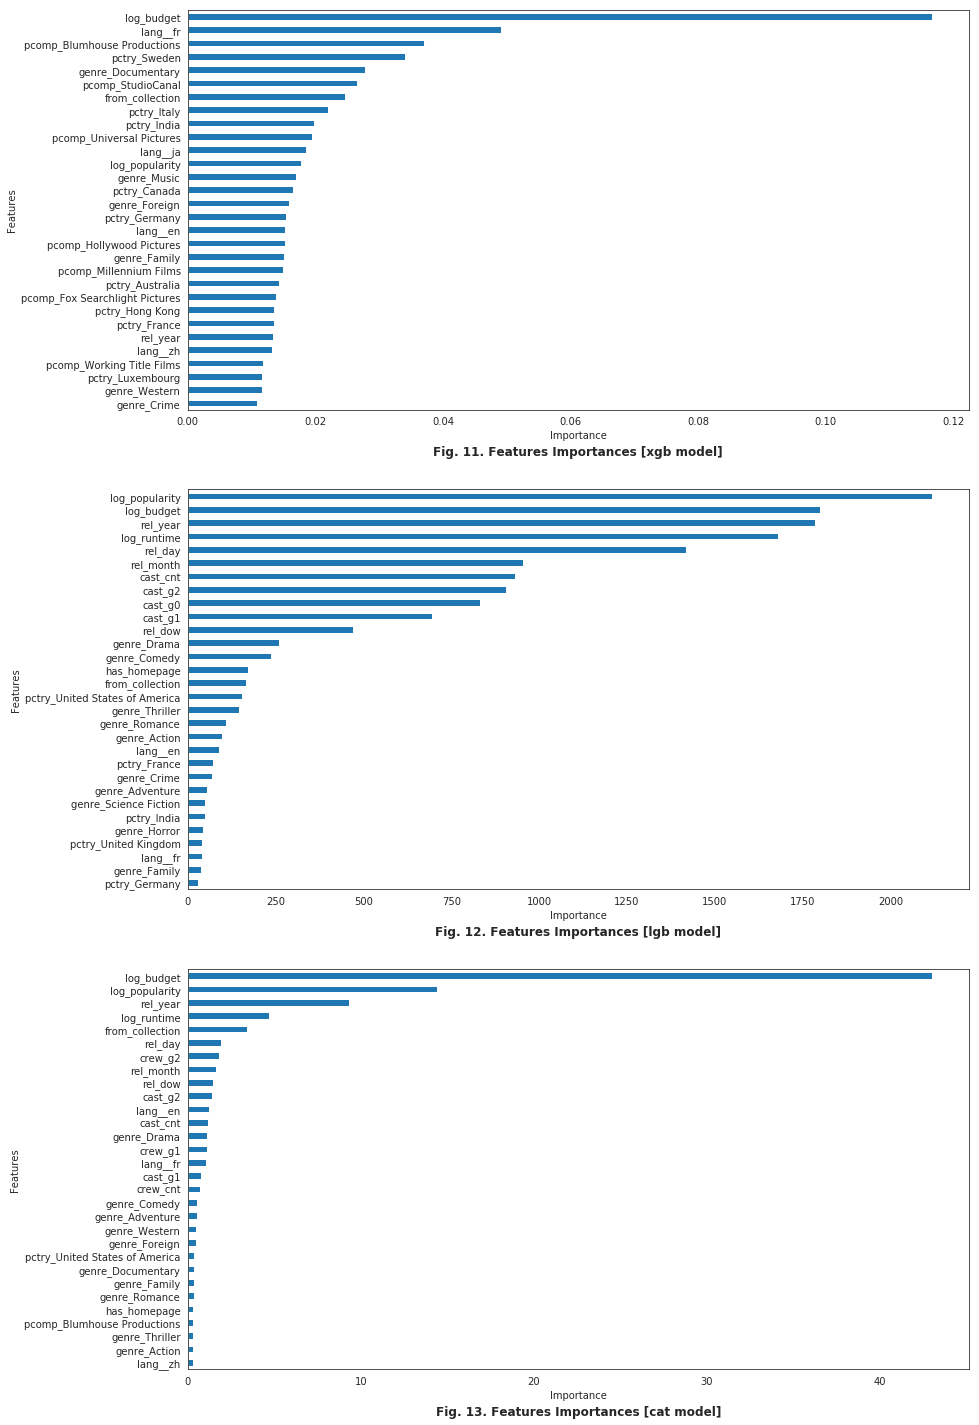

In [68]:
feature_importance = pd.DataFrame(index=movie_pred.data['train'].drop(['revenue'], axis=1).columns)

fig, axes = plt.subplots(3, 1, figsize=(14,25))
#plt.gca().invert_yaxis()
for i,m in enumerate(movie_pred.MOD_CLASS['GBDT']):
    feature_importance[m] = movie_pred.models[m].feature_importances_
    feature_importance[m].sort_values(ascending=False).head(30).plot(kind="barh", ax=axes[i])
    axes[i].invert_yaxis()
    axes[i].set_title("Fig. {}. Features Importances [{} model]".format(i+11,m), fontweight="bold", y=-0.13)
    axes[i].set_xlabel("Importance")
    axes[i].set_ylabel("Features")
    